In [ ]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
import torch.nn.functional as F
from glob import glob
import csv
import random
import re
import os
from PIL import Image
import numpy as np
import sklearn.metrics
import cv2

In [ ]:

data_transform = transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
class image_seg(Dataset):
    def __init__(self, data_dir='' ,transform=data_transform):
        self.transform = data_transform
        self.dirs =glob(data_dir)
    def __len__(self):
        return len(self.dirs)
    def __getitem__(self, idx):
        input = Image.open(self.dirs[idx])
        filename = os.path.basename(self.dirs[idx])
        common_dir = os.path.dirname(os.path.dirname(self.dirs[idx]))
        label_dir = common_dir +'/masks/'+filename[:-4] + '.png'
        label = Image.open(label_dir).convert('L')

        input = input.resize((412,412), Image.LINEAR)
        input = np.array(input).transpose(2,0,1)
        label = label.resize((412,412), Image.NEAREST)
        label = np.array(label)

        #input = self.transform(input)
        #input = torch.from_numpy(np.array(input)[:,0:224,0:224]).float()
        #label = np.array(label)[0:224,0:224]
        label[label==255] = 1
        label = torch.from_numpy(label).long()

        input = torch.from_numpy(input).float()
        return input, label

Dataset_obj_train = image_seg(data_dir ='drive/My Drive/rivers/training/images/**.jpg' ,transform=data_transform)
trainloader = DataLoader(Dataset_obj_train, batch_size=1,shuffle=True)
Dataset_obj_valid = image_seg(data_dir ='drive/My Drive/rivers/test/images/**.jpg',transform=data_transform)
validloader = DataLoader(Dataset_obj_valid, batch_size=1,shuffle=False)

In [ ]:
data_transform = transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
class image_seg(Dataset):
    def __init__(self, data_dir='' ,transform=data_transform):
        self.transform = data_transform
        self.dirs =glob(data_dir)
    def __len__(self):
        return len(self.dirs)
    def __getitem__(self, idx):
        input = Image.open(self.dirs[idx])
        filename = os.path.basename(self.dirs[idx])
        common_dir = os.path.dirname(os.path.dirname(self.dirs[idx]))
        label_dir = common_dir +'/masks/'+filename[:-3] + 'png'
        label = Image.open(label_dir).convert('L')
        input = self.transform(input)
        input = torch.from_numpy(np.array(input)[:,0:412,0:412]).float()
        label = np.array(label)[0:412,0:412]
        label[label==130] = 1
        label = torch.from_numpy(label).long()
        return input, label

Dataset_obj_train = image_seg(data_dir ='drive/My Drive/rivers/training/images/**.jpg' ,transform=data_transform)
trainloader = DataLoader(Dataset_obj_train, batch_size=1,shuffle=True)
Dataset_obj_valid = image_seg(data_dir ='drive/My Drive/rivers/test/images/**.jpg',transform=data_transform)
validloader = DataLoader(Dataset_obj_valid, batch_size=1,shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as t_f

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=2, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = t_f.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    print(x.shape)
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
!cp -r /content/drive/MyDrive/data /content/data

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = torch.nn.CrossEntropyLoss()
net  = UNET()
optimizer = torch.optim.Adam(net.parameters())
net.to(device)
torch.autograd.set_detect_anomaly(False)

best_loss = float('inf')
best_epoch = 0
best_acc = 0
loss_train = []
loss_test = []

from tqdm import tqdm
for epoch in tqdm(range(50)):
    totoal_loss = 0
    net.train()
    for inputs,labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = net(inputs)
        loss = loss_function(logits,labels)
        totoal_loss += loss.item()

        trgt = labels.cpu().detach().numpy().reshape(-1)
        lbl = logits.argmax(dim=1).cpu().detach().numpy().reshape(-1)
        #jsc = sklearn.metrics.jaccard_similarity_score(trgt, lbl)

        loss.backward()
        optimizer.step()
        

    loss_train.append(totoal_loss/len(trainloader))    

    print (f'Epoch: {epoch+1:02} |Loss:{totoal_loss/len(trainloader)}')
    #print (f'Epoch: {epoch+1:02} |Jaccard Loss:{jsc}')

    net.eval()
    with torch.no_grad():
        for inputs,labels in validloader:
            inputs = inputs.to(device)
            labels = labels.to(device)  
            logits = net(inputs)
            loss = loss_function(logits,labels)
        
        loss_test.append(loss.item())            

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch
            torch.save(net.state_dict(), 'best_model.pt')
            
        print("curr_val_loss:",loss.item(), "epoch:", epoch+1, "best_loss",best_loss.item(),"best_epoch",best_epoch)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 |Loss:0.5837900956471761



  2%|▏         | 1/50 [00:18<15:10, 18.58s/it]

curr_val_loss: 0.4729700982570648 epoch: 1 best_loss 0.4729700982570648 best_epoch 0
Epoch: 02 |Loss:0.4613083799680074



  4%|▍         | 2/50 [00:29<13:00, 16.27s/it]

curr_val_loss: 0.34789034724235535 epoch: 2 best_loss 0.34789034724235535 best_epoch 1
Epoch: 03 |Loss:0.4689549962679545



  6%|▌         | 3/50 [00:40<11:28, 14.64s/it]

curr_val_loss: 0.24905209243297577 epoch: 3 best_loss 0.24905209243297577 best_epoch 2
Epoch: 04 |Loss:0.41367311278978985



  8%|▊         | 4/50 [00:51<10:20, 13.49s/it]

curr_val_loss: 0.20743197202682495 epoch: 4 best_loss 0.20743197202682495 best_epoch 3
Epoch: 05 |Loss:0.4390445570151011



 10%|█         | 5/50 [01:01<09:27, 12.62s/it]

curr_val_loss: 0.25730589032173157 epoch: 5 best_loss 0.20743197202682495 best_epoch 3
Epoch: 06 |Loss:0.42827964822451275



 12%|█▏        | 6/50 [01:12<08:48, 12.01s/it]

curr_val_loss: 0.22659023106098175 epoch: 6 best_loss 0.20743197202682495 best_epoch 3
Epoch: 07 |Loss:0.4145161231358846



 14%|█▍        | 7/50 [01:22<08:17, 11.58s/it]

curr_val_loss: 0.21272999048233032 epoch: 7 best_loss 0.20743197202682495 best_epoch 3
Epoch: 08 |Loss:0.4278018077214559



 16%|█▌        | 8/50 [01:33<07:53, 11.28s/it]

curr_val_loss: 0.320365309715271 epoch: 8 best_loss 0.20743197202682495 best_epoch 3
Epoch: 09 |Loss:0.4568010131518046



 18%|█▊        | 9/50 [01:44<07:34, 11.08s/it]

curr_val_loss: 0.2234095185995102 epoch: 9 best_loss 0.20743197202682495 best_epoch 3
Epoch: 10 |Loss:0.422795844078064



 20%|██        | 10/50 [01:54<07:20, 11.01s/it]

curr_val_loss: 0.1683468222618103 epoch: 10 best_loss 0.1683468222618103 best_epoch 9
Epoch: 11 |Loss:0.439369934797287



 22%|██▏       | 11/50 [02:05<07:04, 10.88s/it]

curr_val_loss: 0.1994767189025879 epoch: 11 best_loss 0.1683468222618103 best_epoch 9
Epoch: 12 |Loss:0.45667136609554293



 24%|██▍       | 12/50 [02:16<06:50, 10.79s/it]

curr_val_loss: 0.2141370326280594 epoch: 12 best_loss 0.1683468222618103 best_epoch 9
Epoch: 13 |Loss:0.43291276892026265



 26%|██▌       | 13/50 [02:26<06:37, 10.74s/it]

curr_val_loss: 0.18317614495754242 epoch: 13 best_loss 0.1683468222618103 best_epoch 9
Epoch: 14 |Loss:0.43483516077200574



 28%|██▊       | 14/50 [02:37<06:24, 10.69s/it]

curr_val_loss: 0.176670104265213 epoch: 14 best_loss 0.1683468222618103 best_epoch 9
Epoch: 15 |Loss:0.39874834020932515



 30%|███       | 15/50 [02:47<06:13, 10.66s/it]

curr_val_loss: 0.18713779747486115 epoch: 15 best_loss 0.1683468222618103 best_epoch 9
Epoch: 16 |Loss:0.3728667696317037



 32%|███▏      | 16/50 [02:58<06:01, 10.64s/it]

curr_val_loss: 0.22205819189548492 epoch: 16 best_loss 0.1683468222618103 best_epoch 9
Epoch: 17 |Loss:0.4259184638659159



 34%|███▍      | 17/50 [03:08<05:50, 10.61s/it]

curr_val_loss: 0.18427500128746033 epoch: 17 best_loss 0.1683468222618103 best_epoch 9
Epoch: 18 |Loss:0.39062740008036295



 36%|███▌      | 18/50 [03:19<05:39, 10.62s/it]

curr_val_loss: 0.17784544825553894 epoch: 18 best_loss 0.1683468222618103 best_epoch 9
Epoch: 19 |Loss:0.42794210414091743



 38%|███▊      | 19/50 [03:30<05:28, 10.61s/it]

curr_val_loss: 0.17543193697929382 epoch: 19 best_loss 0.1683468222618103 best_epoch 9
Epoch: 20 |Loss:0.35157320102055867



 40%|████      | 20/50 [03:40<05:18, 10.61s/it]

curr_val_loss: 0.19860149919986725 epoch: 20 best_loss 0.1683468222618103 best_epoch 9
Epoch: 21 |Loss:0.432821586728096



 42%|████▏     | 21/50 [03:51<05:07, 10.60s/it]

curr_val_loss: 0.18340866267681122 epoch: 21 best_loss 0.1683468222618103 best_epoch 9
Epoch: 22 |Loss:0.41629547576109566



 44%|████▍     | 22/50 [04:02<04:58, 10.66s/it]

curr_val_loss: 0.16730047762393951 epoch: 22 best_loss 0.16730047762393951 best_epoch 21
Epoch: 23 |Loss:0.46272486050923667



 46%|████▌     | 23/50 [04:12<04:47, 10.63s/it]

curr_val_loss: 0.20663556456565857 epoch: 23 best_loss 0.16730047762393951 best_epoch 21
Epoch: 24 |Loss:0.41589081287384033



 48%|████▊     | 24/50 [04:23<04:36, 10.62s/it]

curr_val_loss: 0.17615610361099243 epoch: 24 best_loss 0.16730047762393951 best_epoch 21
Epoch: 25 |Loss:0.4160518358151118



 50%|█████     | 25/50 [04:33<04:25, 10.60s/it]

curr_val_loss: 0.18336519598960876 epoch: 25 best_loss 0.16730047762393951 best_epoch 21
Epoch: 26 |Loss:0.43412922918796537



 52%|█████▏    | 26/50 [04:44<04:14, 10.61s/it]

curr_val_loss: 0.1967758685350418 epoch: 26 best_loss 0.16730047762393951 best_epoch 21
Epoch: 27 |Loss:0.4061278760433197



 54%|█████▍    | 27/50 [04:55<04:03, 10.60s/it]

curr_val_loss: 0.18998271226882935 epoch: 27 best_loss 0.16730047762393951 best_epoch 21
Epoch: 28 |Loss:0.3652797003587087



 56%|█████▌    | 28/50 [05:05<03:53, 10.59s/it]

curr_val_loss: 0.19070769846439362 epoch: 28 best_loss 0.16730047762393951 best_epoch 21
Epoch: 29 |Loss:0.42466185490290326



 58%|█████▊    | 29/50 [05:16<03:42, 10.60s/it]

curr_val_loss: 0.23672877252101898 epoch: 29 best_loss 0.16730047762393951 best_epoch 21
Epoch: 30 |Loss:0.4031194746494293



 60%|██████    | 30/50 [05:26<03:31, 10.59s/it]

curr_val_loss: 0.17736342549324036 epoch: 30 best_loss 0.16730047762393951 best_epoch 21
Epoch: 31 |Loss:0.3706709404786428



 62%|██████▏   | 31/50 [05:37<03:21, 10.58s/it]

curr_val_loss: 0.17993034422397614 epoch: 31 best_loss 0.16730047762393951 best_epoch 21
Epoch: 32 |Loss:0.37859207491079966



 64%|██████▍   | 32/50 [05:47<03:10, 10.58s/it]

curr_val_loss: 0.19285669922828674 epoch: 32 best_loss 0.16730047762393951 best_epoch 21
Epoch: 33 |Loss:0.3839842577775319



 66%|██████▌   | 33/50 [05:58<02:59, 10.58s/it]

curr_val_loss: 0.18257199227809906 epoch: 33 best_loss 0.16730047762393951 best_epoch 21
Epoch: 34 |Loss:0.39408962428569794



 68%|██████▊   | 34/50 [06:09<02:49, 10.59s/it]

curr_val_loss: 0.1750759482383728 epoch: 34 best_loss 0.16730047762393951 best_epoch 21
Epoch: 35 |Loss:0.3655501425266266



 70%|███████   | 35/50 [06:19<02:38, 10.58s/it]

curr_val_loss: 0.1688065379858017 epoch: 35 best_loss 0.16730047762393951 best_epoch 21
Epoch: 36 |Loss:0.3991002728541692



 72%|███████▏  | 36/50 [06:30<02:29, 10.65s/it]

curr_val_loss: 0.16023975610733032 epoch: 36 best_loss 0.16023975610733032 best_epoch 35
Epoch: 37 |Loss:0.3588679313659668



 74%|███████▍  | 37/50 [06:41<02:18, 10.63s/it]

curr_val_loss: 0.20888924598693848 epoch: 37 best_loss 0.16023975610733032 best_epoch 35
Epoch: 38 |Loss:0.41302003264427184



 76%|███████▌  | 38/50 [06:51<02:07, 10.61s/it]

curr_val_loss: 0.1874450147151947 epoch: 38 best_loss 0.16023975610733032 best_epoch 35
Epoch: 39 |Loss:0.3639506290356318



 78%|███████▊  | 39/50 [07:02<01:56, 10.60s/it]

curr_val_loss: 0.16896359622478485 epoch: 39 best_loss 0.16023975610733032 best_epoch 35
Epoch: 40 |Loss:0.42134834825992584



 80%|████████  | 40/50 [07:12<01:45, 10.58s/it]

curr_val_loss: 0.1811288297176361 epoch: 40 best_loss 0.16023975610733032 best_epoch 35
Epoch: 41 |Loss:0.37325636943181356



 82%|████████▏ | 41/50 [07:23<01:35, 10.59s/it]

curr_val_loss: 0.18293528258800507 epoch: 41 best_loss 0.16023975610733032 best_epoch 35
Epoch: 42 |Loss:0.3908470491568247



 84%|████████▍ | 42/50 [07:33<01:24, 10.58s/it]

curr_val_loss: 0.2053932100534439 epoch: 42 best_loss 0.16023975610733032 best_epoch 35
Epoch: 43 |Loss:0.4240082293748856



 86%|████████▌ | 43/50 [07:44<01:14, 10.58s/it]

curr_val_loss: 0.201931431889534 epoch: 43 best_loss 0.16023975610733032 best_epoch 35
Epoch: 44 |Loss:0.3677233467499415



 88%|████████▊ | 44/50 [07:55<01:03, 10.58s/it]

curr_val_loss: 0.1799648106098175 epoch: 44 best_loss 0.16023975610733032 best_epoch 35
Epoch: 45 |Loss:0.3692587226629257



 90%|█████████ | 45/50 [08:05<00:52, 10.58s/it]

curr_val_loss: 0.20910434424877167 epoch: 45 best_loss 0.16023975610733032 best_epoch 35
Epoch: 46 |Loss:0.37333250840504967



 92%|█████████▏| 46/50 [08:16<00:42, 10.57s/it]

curr_val_loss: 0.1855032593011856 epoch: 46 best_loss 0.16023975610733032 best_epoch 35
Epoch: 47 |Loss:0.37000776727994283



 94%|█████████▍| 47/50 [08:26<00:31, 10.58s/it]

curr_val_loss: 0.1858314722776413 epoch: 47 best_loss 0.16023975610733032 best_epoch 35
Epoch: 48 |Loss:0.39807397027810415



 96%|█████████▌| 48/50 [08:37<00:21, 10.58s/it]

curr_val_loss: 0.16945253312587738 epoch: 48 best_loss 0.16023975610733032 best_epoch 35
Epoch: 49 |Loss:0.3973498553037643



 98%|█████████▊| 49/50 [08:48<00:10, 10.58s/it]

curr_val_loss: 0.22052355110645294 epoch: 49 best_loss 0.16023975610733032 best_epoch 35
Epoch: 50 |Loss:0.3648102482159932



100%|██████████| 50/50 [08:58<00:00, 10.77s/it]

curr_val_loss: 0.16364817321300507 epoch: 50 best_loss 0.16023975610733032 best_epoch 35


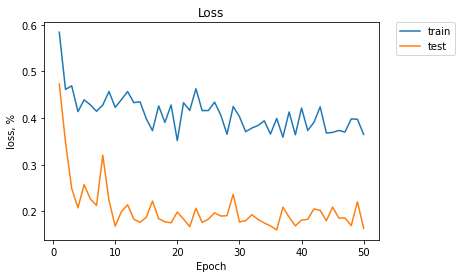

In [ ]:
import matplotlib.pyplot as plt
names = ["train", "test"]
loss = [loss_train, loss_test]

for i in range(len(names)):
    plt.plot(range(1, 51), loss[i], label=names[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('loss, %')
plt.title('Loss')

plt.show()

In [ ]:
net.load_state_dict(torch.load('best_model.pt'))

total_f1 = 0
total_jaccard = 0
preds = []
ans = []
k = 0

for input,label in validloader:
    input = input.to(device)
    logit = net(input)
    pred = logit.argmax(dim=1)
    preds.append(pred)
    ans.append(label)
    matplotlib.image.imsave('pred' + str(k) +'.png', pred[0].cpu().numpy())
    matplotlib.image.imsave('labels' + str(k) + '.png', label[0].cpu().numpy())
    trgt = label.cpu().detach().numpy().reshape(-1)
    res = logit.argmax(dim=1).cpu().detach().numpy().reshape(-1)
    jsc = sklearn.metrics.jaccard_similarity_score(trgt, res)
    f1 = sklearn.metrics.f1_score(trgt, res)
    total_f1 += f1
    total_jaccard += jsc
    k += 1

print("Average metrics on valid dataset: \n")
print (f'Jaccard loss : {total_jaccard/len(validloader)} \nFi-score : {total_f1/len(validloader)}')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Average metrics on valid dataset: 

Jaccard loss : 0.7869026298425865 
Fi-score : 0.13718715494747533


label                                                                                                         predict


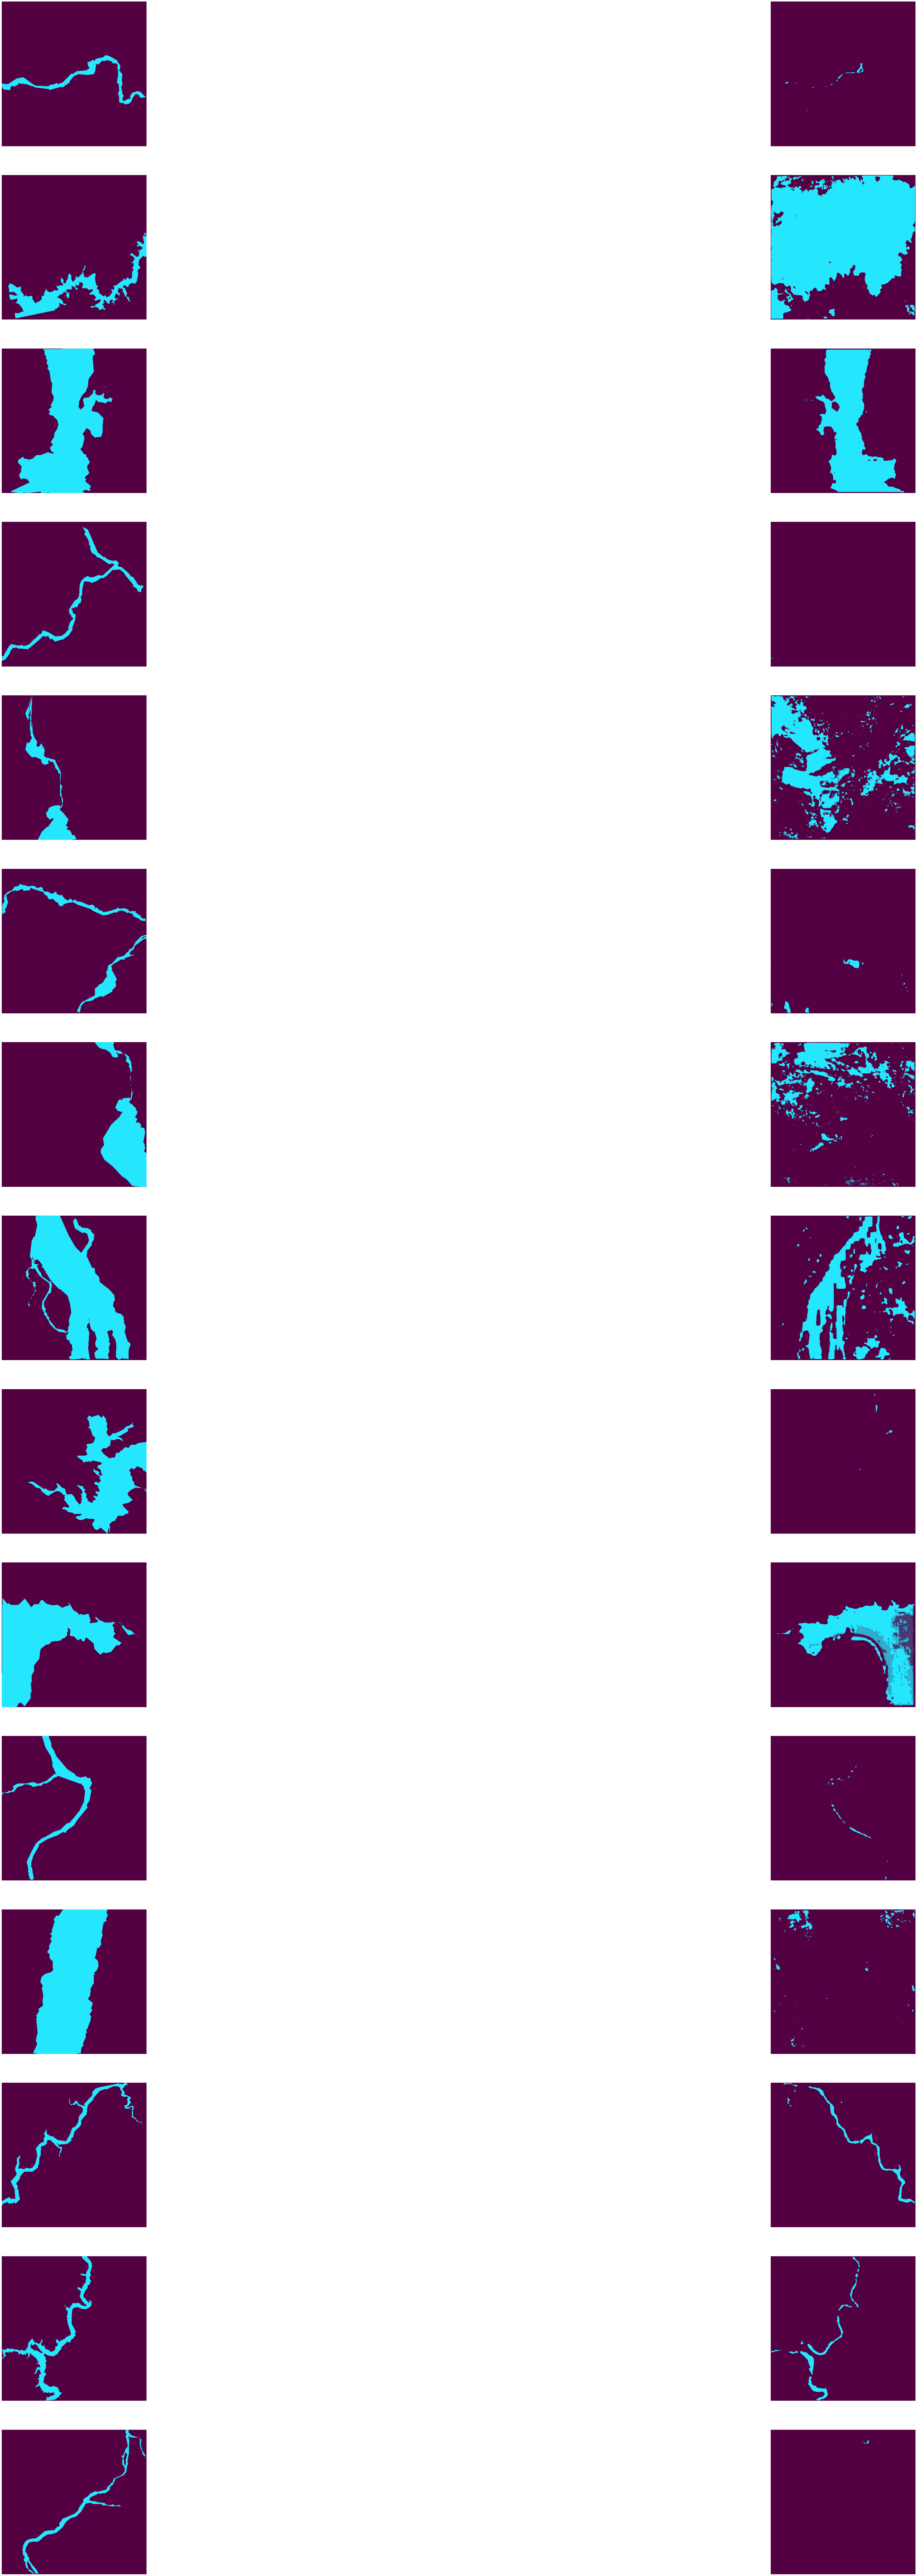

In [ ]:
import matplotlib.pyplot as plt

pic_box = plt.figure(figsize=(100, 200))
print("label                                                                                                         predict")

for i in range(len(preds)):
    picture = cv2.imread('/content/labels' + str(i) + '.png')
    pic_box.add_subplot(16,2,i*2 + 1)
    plt.imshow(picture)
    plt.axis('off')

    picture = cv2.imread('/content/pred' + str(i) + '.png')
    pic_box.add_subplot(16, 2, i*2 + 2)
    plt.imshow(picture)
    plt.axis('off')
plt.show() 